In [5]:
!pip install -q transformers opendatasets emoji scikit-learn optuna

import os, re, time, random, json
import emoji
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 42.0 MB/s eta 0:00:00


In [6]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/sandhyapeesara/cyberbullying-detection-dataset",
    data_dir=".",
    force=True
)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: spacekeggle
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sandhyapeesara/cyberbullying-detection-dataset


100%|██████████| 6.51M/6.51M [00:00<00:00, 1.50GB/s]

In [7]:
import os
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Available Device:", device)


Available Device: cuda


In [8]:
def textFixNormlize(text):
    text = str(text).lower()
    text = re.sub(r"\S+@\S+\.\S+", "", text)     # remove emails
    text = re.sub(r'@\w+', '', text)            # remove mentions
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'#(\w+)', r'\1', text)       # remove hashtag symbol only
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data_df = pd.read_json(
    "/content/cyberbullying-detection-dataset/Cyber_Bully_Data.json",
    lines=True
)

data_df["clean_text"] = data_df["text"].astype(str).apply(textFixNormlize)

le = LabelEncoder()
data_df["label_id"] = le.fit_transform(data_df["label"])

data_df.dropna(subset=["clean_text", "label_id"], inplace=True)
data_df.drop_duplicates(subset=["clean_text", "label_id"], inplace=True)

print("Shape after cleaning:", data_df.shape)
print("Labels:", list(le.classes_))
data_df.head()


Shape after cleaning: (99967, 4)
Labels: ['ethnicity/race', 'gender/sexual', 'not_cyberbullying', 'religion']


,text,label,clean_text,label_id
0,@ZubearSays Any real nigga isn't letting this ...,ethnicity/race,any real nigga isn't letting this happen.,0
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,not_cyberbullying,"i didn't even mention mexico, but the us is fa...",2
2,"the only thing i wish, i wish a nigga would",ethnicity/race,"the only thing i wish, i wish a nigga would",0
3,You saudias are not friends of Muslim idiots c...,religion,you saudias are not friends of muslim idiots c...,3
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,religion,and yet the maga want to do just that. the jud...,3


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Class distribution:
label
not_cyberbullying    49983
ethnicity/race       17000
gender/sexual        17000
religion             15984
Name: count, dtype: int64

Character length stats:
count    99967.000000
mean       124.464573
std         82.829636
min          4.000000
25%         60.000000
50%        101.000000
75%        174.000000
max       2541.000000
Name: char_len, dtype: float64


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors



Token length stats:
count    99967.000000
mean        33.508908
std         21.932995
min          1.000000
25%         17.000000
50%         29.000000
75%         47.000000
max        687.000000
Name: tok_len, dtype: float64


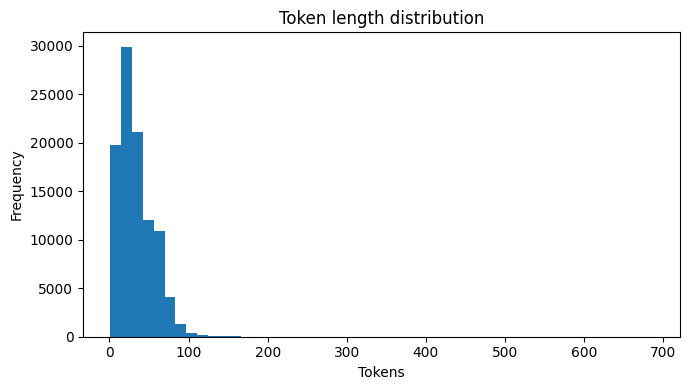

In [9]:
MODEL_NAME = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Class distribution:")
print(data_df["label"].value_counts())

data_df["char_len"] = data_df["clean_text"].str.len()
print("\nCharacter length stats:")
print(data_df["char_len"].describe())

data_df["tok_len"] = data_df["clean_text"].apply(lambda x: len(tokenizer.tokenize(str(x))))
print("\nToken length stats:")
print(data_df["tok_len"].describe())

plt.figure(figsize=(7,4))
plt.hist(data_df["tok_len"], bins=50)
plt.title("Token length distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [10]:
X = np.array(data_df["clean_text"])
y = np.array(data_df["label_id"])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.50, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)/len(X)*100:.2f}%")
print(f"Val:   {len(X_val)/len(X)*100:.2f}%")
print(f"Test:  {len(X_test)/len(X)*100:.2f}%")


Train: 50.00%
Val:   25.00%
Test:  25.00%


In [11]:
class MyDataset(Dataset):
    def __init__(self, X, Y, tokenizer, max_len):
        self.X = X
        self.Y = Y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = str(self.X[idx])
        label = int(self.Y[idx])

        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [12]:
class MyModel(nn.Module):
    def __init__(self, base_model, num_classes, dropout=0.30):
        super().__init__()
        self.base = base_model
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 256)
        self.act = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.base(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]
        x = self.dropout1(cls)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout2(x)
        return self.fc2(x)


In [13]:
def run_bert_experiment(
    run_name="bert_run",
    max_len=100,
    batch_size=32,
    epochs=3,
    lr=2e-5,
    dropout=0.30,
    unfreeze_last_n=2,
    save_dir="results_bert"
):
    os.makedirs(save_dir, exist_ok=True)

    # Fresh tokenizer/model for fair runs
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    base_model = AutoModel.from_pretrained(MODEL_NAME)

    num_classes = len(le.classes_)

    # DataLoaders
    train_loader = DataLoader(MyDataset(X_train, y_train, tokenizer, max_len), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(MyDataset(X_val, y_val, tokenizer, max_len), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(MyDataset(X_test, y_test, tokenizer, max_len), batch_size=batch_size, shuffle=False)

    # Class weights (helps imbalance)
    classes = np.unique(y_train)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    cw = torch.tensor(cw, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=cw)

    model = MyModel(base_model, num_classes, dropout=dropout).to(device)

    # Freeze all then unfreeze last N transformer layers
    for p in model.base.parameters():
        p.requires_grad = False
    for p in model.base.encoder.layer[-unfreeze_last_n:].parameters():
        p.requires_grad = True

    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_acc = -1.0
    best_ckpt_path = os.path.join(save_dir, f"{run_name}_best.pt")

    # Timing (7)
    start_time = time.time()

    for epoch in range(epochs):
        # ---- TRAIN
        model.train()
        train_loss_sum, train_correct, train_total = 0.0, 0, 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss_sum / train_total
        avg_train_acc = train_correct / train_total

        # ---- VAL
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

                val_loss_sum += loss.item() * labels.size(0)
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss_sum / val_total
        avg_val_acc = val_correct / val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(avg_train_acc)
        history["val_acc"].append(avg_val_acc)

        print(f"[{run_name}] Epoch {epoch+1}/{epochs} | "
              f"Train Loss {avg_train_loss:.4f} Acc {avg_train_acc*100:.2f}% | "
              f"Val Loss {avg_val_loss:.4f} Acc {avg_val_acc*100:.2f}%")

        # Best checkpoint (4)
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save({
                "model_state": model.state_dict(),
                "label_classes": le.classes_,
                "config": {
                    "model_name": MODEL_NAME,
                    "max_len": max_len,
                    "batch_size": batch_size,
                    "epochs": epochs,
                    "lr": lr,
                    "dropout": dropout,
                    "unfreeze_last_n": unfreeze_last_n
                }
            }, best_ckpt_path)
            print(f"✅ Saved BEST checkpoint: {best_ckpt_path} (Val Acc {best_val_acc*100:.2f}%)")

    train_time_sec = time.time() - start_time
    print(f"[{run_name}] Training time: {train_time_sec:.2f} seconds")

    # ---- Load best checkpoint
    ckpt = torch.load(best_ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    # ---- TEST (3)
    all_preds, all_labels = [], []
    test_loss_sum, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            test_loss_sum += loss.item() * labels.size(0)

            preds = torch.argmax(logits, dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    avg_test_loss = test_loss_sum / test_total
    avg_test_acc = test_correct / test_total

    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")
    macro_prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_rec  = recall_score(all_labels, all_preds, average="macro", zero_division=0)

    metrics = {
        "run_name": run_name,
        "best_val_acc": float(best_val_acc),
        "test_loss": float(avg_test_loss),
        "test_acc": float(avg_test_acc),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1),
        "macro_precision": float(macro_prec),
        "macro_recall": float(macro_rec),
        "training_time_sec": float(train_time_sec),
        "best_checkpoint": best_ckpt_path,
        "config": ckpt["config"]
    }

    print(f"\nTEST RESULTS | Loss: {avg_test_loss:.4f} | Accuracy: {avg_test_acc*100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))
    print("Confusion Matrix (numbers):")
    print(confusion_matrix(all_labels, all_preds))

    # Colored confusion matrix diagram (required)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(values_format="d")  # colored by default
    plt.title(f"Confusion Matrix (Counts) — {run_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Save outputs (6)
    pred_df = pd.DataFrame({
        "text": X_test,
        "true_label": [le.classes_[i] for i in y_test],
        "pred_label": [le.classes_[i] for i in all_preds]
    })
    pred_path = os.path.join(save_dir, f"{run_name}_test_predictions.csv")
    pred_df.to_csv(pred_path, index=False)

    metrics_path = os.path.join(save_dir, f"{run_name}_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)

    history_path = os.path.join(save_dir, f"{run_name}_history.csv")
    pd.DataFrame(history).to_csv(history_path, index=False)

    print("✅ Saved predictions:", pred_path)
    print("✅ Saved metrics:", metrics_path)
    print("✅ Saved history:", history_path)

    return metrics, history


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[bert_baseline] Epoch 1/3 | Train Loss 0.1562 Acc 95.30% | Val Loss 0.0439 Acc 99.04%
✅ Saved BEST checkpoint: results_bert/baseline/bert_baseline_best.pt (Val Acc 99.04%)
[bert_baseline] Epoch 2/3 | Train Loss 0.0374 Acc 99.12% | Val Loss 0.0374 Acc 99.05%
✅ Saved BEST checkpoint: results_bert/baseline/bert_baseline_best.pt (Val Acc 99.05%)
[bert_baseline] Epoch 3/3 | Train Loss 0.0273 Acc 99.32% | Val Loss 0.0322 Acc 99.34%
✅ Saved BEST checkpoint: results_bert/baseline/bert_baseline_best.pt (Val Acc 99.34%)
[bert_baseline] Training time: 717.78 seconds

TEST RESULTS | Loss: 0.0285 | Accuracy: 99.43%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       1.00      0.99      0.99      4250
not_cyberbullying       0.99      1.00      1.00     12496
         religion       0.99      0.99      0.99      3996

         accuracy                           0.99     24992
        ma

<Figure size 700x600 with 0 Axes>

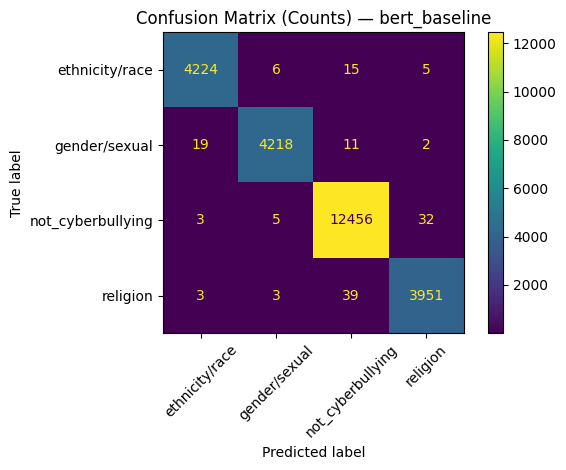

✅ Saved predictions: results_bert/baseline/bert_baseline_test_predictions.csv
✅ Saved metrics: results_bert/baseline/bert_baseline_metrics.json
✅ Saved history: results_bert/baseline/bert_baseline_history.csv


In [14]:
set_seed(42)

baseline_metrics, baseline_history = run_bert_experiment(
    run_name="bert_baseline",
    max_len=100,
    batch_size=32,
    epochs=3,
    lr=2e-5,
    dropout=0.30,
    unfreeze_last_n=2,
    save_dir="results_bert/baseline"
)


[bert_manual_1_lr2e-05_len100_do0.3] Epoch 1/2 | Train Loss 0.1562 Acc 95.30% | Val Loss 0.0439 Acc 99.04%
✅ Saved BEST checkpoint: results_bert/manual_search/bert_manual_1_lr2e-05_len100_do0.3_best.pt (Val Acc 99.04%)
[bert_manual_1_lr2e-05_len100_do0.3] Epoch 2/2 | Train Loss 0.0374 Acc 99.12% | Val Loss 0.0374 Acc 99.05%
✅ Saved BEST checkpoint: results_bert/manual_search/bert_manual_1_lr2e-05_len100_do0.3_best.pt (Val Acc 99.05%)
[bert_manual_1_lr2e-05_len100_do0.3] Training time: 485.82 seconds

TEST RESULTS | Loss: 0.0328 | Accuracy: 99.13%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       1.00      0.99      0.99     12496
         religion       0.98      0.99      0.99      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     wei

<Figure size 700x600 with 0 Axes>

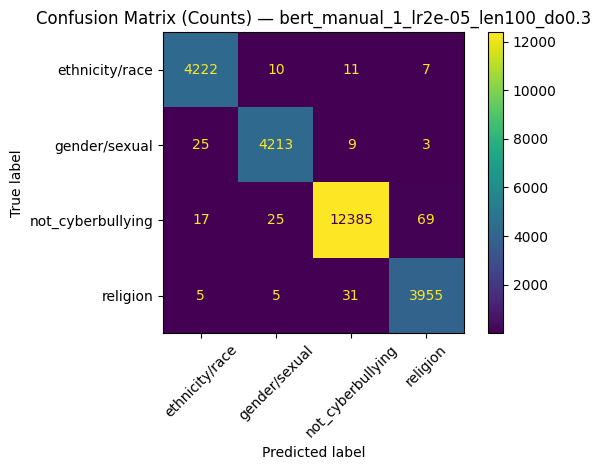

✅ Saved predictions: results_bert/manual_search/bert_manual_1_lr2e-05_len100_do0.3_test_predictions.csv
✅ Saved metrics: results_bert/manual_search/bert_manual_1_lr2e-05_len100_do0.3_metrics.json
✅ Saved history: results_bert/manual_search/bert_manual_1_lr2e-05_len100_do0.3_history.csv
[bert_manual_2_lr3e-05_len100_do0.3] Epoch 1/2 | Train Loss 0.1259 Acc 96.32% | Val Loss 0.0434 Acc 99.04%
✅ Saved BEST checkpoint: results_bert/manual_search/bert_manual_2_lr3e-05_len100_do0.3_best.pt (Val Acc 99.04%)
[bert_manual_2_lr3e-05_len100_do0.3] Epoch 2/2 | Train Loss 0.0345 Acc 99.20% | Val Loss 0.0359 Acc 99.13%
✅ Saved BEST checkpoint: results_bert/manual_search/bert_manual_2_lr3e-05_len100_do0.3_best.pt (Val Acc 99.13%)
[bert_manual_2_lr3e-05_len100_do0.3] Training time: 483.10 seconds

TEST RESULTS | Loss: 0.0312 | Accuracy: 99.23%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual

<Figure size 700x600 with 0 Axes>

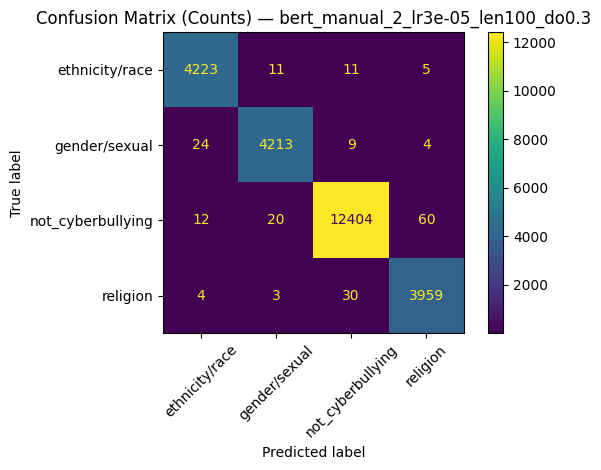

✅ Saved predictions: results_bert/manual_search/bert_manual_2_lr3e-05_len100_do0.3_test_predictions.csv
✅ Saved metrics: results_bert/manual_search/bert_manual_2_lr3e-05_len100_do0.3_metrics.json
✅ Saved history: results_bert/manual_search/bert_manual_2_lr3e-05_len100_do0.3_history.csv
[bert_manual_3_lr2e-05_len128_do0.3] Epoch 1/2 | Train Loss 0.1583 Acc 95.28% | Val Loss 0.0476 Acc 99.00%
✅ Saved BEST checkpoint: results_bert/manual_search/bert_manual_3_lr2e-05_len128_do0.3_best.pt (Val Acc 99.00%)
[bert_manual_3_lr2e-05_len128_do0.3] Epoch 2/2 | Train Loss 0.0381 Acc 99.07% | Val Loss 0.0367 Acc 99.16%
✅ Saved BEST checkpoint: results_bert/manual_search/bert_manual_3_lr2e-05_len128_do0.3_best.pt (Val Acc 99.16%)
[bert_manual_3_lr2e-05_len128_do0.3] Training time: 605.33 seconds

TEST RESULTS | Loss: 0.0339 | Accuracy: 99.26%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual

<Figure size 700x600 with 0 Axes>

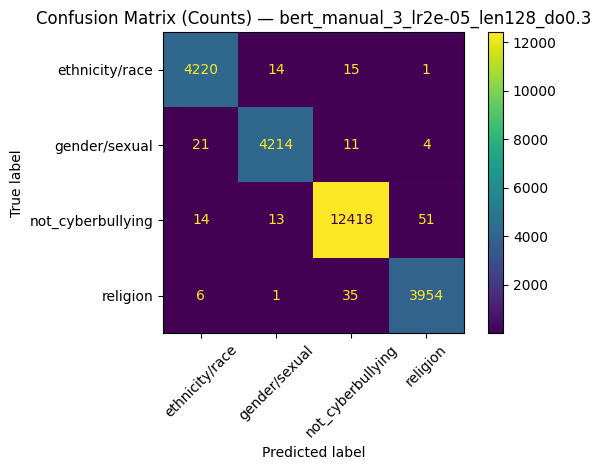

✅ Saved predictions: results_bert/manual_search/bert_manual_3_lr2e-05_len128_do0.3_test_predictions.csv
✅ Saved metrics: results_bert/manual_search/bert_manual_3_lr2e-05_len128_do0.3_metrics.json
✅ Saved history: results_bert/manual_search/bert_manual_3_lr2e-05_len128_do0.3_history.csv
[bert_manual_4_lr2e-05_len100_do0.4] Epoch 1/2 | Train Loss 0.1696 Acc 94.88% | Val Loss 0.0443 Acc 99.01%
✅ Saved BEST checkpoint: results_bert/manual_search/bert_manual_4_lr2e-05_len100_do0.4_best.pt (Val Acc 99.01%)
[bert_manual_4_lr2e-05_len100_do0.4] Epoch 2/2 | Train Loss 0.0394 Acc 99.06% | Val Loss 0.0374 Acc 99.01%
[bert_manual_4_lr2e-05_len100_do0.4] Training time: 483.72 seconds

TEST RESULTS | Loss: 0.0406 | Accuracy: 99.09%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.98      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         re

<Figure size 700x600 with 0 Axes>

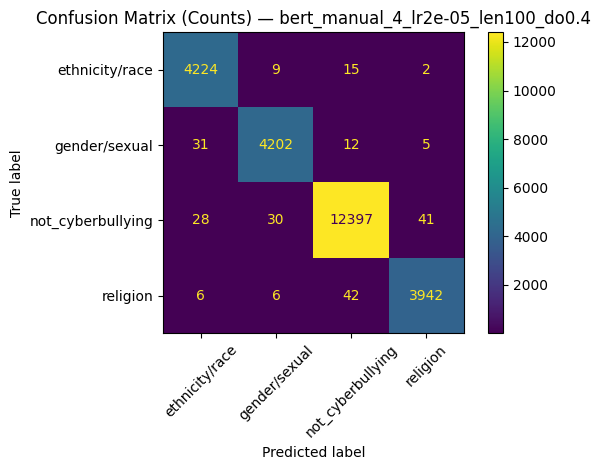

✅ Saved predictions: results_bert/manual_search/bert_manual_4_lr2e-05_len100_do0.4_test_predictions.csv
✅ Saved metrics: results_bert/manual_search/bert_manual_4_lr2e-05_len100_do0.4_metrics.json
✅ Saved history: results_bert/manual_search/bert_manual_4_lr2e-05_len100_do0.4_history.csv


,run_name,best_val_acc,test_acc,macro_f1,training_time_sec
2,bert_manual_3_lr2e-05_len128_do0.3,0.991557,0.992558,0.991579,605.326192
1,bert_manual_2_lr3e-05_len100_do0.3,0.991277,0.992278,0.991218,483.103452
0,bert_manual_1_lr2e-05_len100_do0.3,0.990517,0.991317,0.990175,485.818603
3,bert_manual_4_lr2e-05_len100_do0.4,0.990117,0.990917,0.989724,483.723073


In [15]:
manual_space = [
    {"lr": 2e-5, "max_len": 100, "dropout": 0.30},
    {"lr": 3e-5, "max_len": 100, "dropout": 0.30},
    {"lr": 2e-5, "max_len": 128, "dropout": 0.30},
    {"lr": 2e-5, "max_len": 100, "dropout": 0.40},
]

manual_results = []

for i, cfg in enumerate(manual_space, start=1):
    set_seed(42)
    run_name = f"bert_manual_{i}_lr{cfg['lr']}_len{cfg['max_len']}_do{cfg['dropout']}"
    metrics, _ = run_bert_experiment(
        run_name=run_name,
        max_len=cfg["max_len"],
        batch_size=32,
        epochs=2,              # short for tuning
        lr=cfg["lr"],
        dropout=cfg["dropout"],
        unfreeze_last_n=2,
        save_dir="results_bert/manual_search"
    )
    manual_results.append(metrics)

manual_df = pd.DataFrame(manual_results).sort_values("best_val_acc", ascending=False)
manual_df[["run_name","best_val_acc","test_acc","macro_f1","training_time_sec"]]


[I 2025-12-16 14:28:16,153] A new study created in memory with name: no-name-9eff0aa4-2982-4840-9b77-2398f30f3b92


[bert_optuna_lr1.85e-05_len128_do0.41] Epoch 1/2 | Train Loss 0.1810 Acc 94.42% | Val Loss 0.0473 Acc 98.95%
✅ Saved BEST checkpoint: results_bert/optuna_search/bert_optuna_lr1.85e-05_len128_do0.41_best.pt (Val Acc 98.95%)
[bert_optuna_lr1.85e-05_len128_do0.41] Epoch 2/2 | Train Loss 0.0411 Acc 99.02% | Val Loss 0.0373 Acc 99.15%
✅ Saved BEST checkpoint: results_bert/optuna_search/bert_optuna_lr1.85e-05_len128_do0.41_best.pt (Val Acc 99.15%)
[bert_optuna_lr1.85e-05_len128_do0.41] Training time: 606.20 seconds

TEST RESULTS | Loss: 0.0357 | Accuracy: 99.18%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       1.00      0.99      0.99     12496
         religion       0.98      0.99      0.99      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     2499

<Figure size 700x600 with 0 Axes>

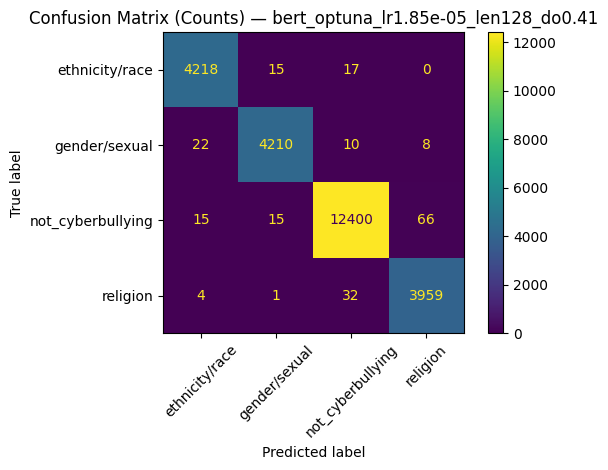

[I 2025-12-16 14:39:47,675] Trial 0 finished with value: 0.9914772727272727 and parameters: {'lr': 1.850688312971912e-05, 'max_len': 128, 'dropout': 0.4067660393994582}. Best is trial 0 with value: 0.9914772727272727.


✅ Saved predictions: results_bert/optuna_search/bert_optuna_lr1.85e-05_len128_do0.41_test_predictions.csv
✅ Saved metrics: results_bert/optuna_search/bert_optuna_lr1.85e-05_len128_do0.41_metrics.json
✅ Saved history: results_bert/optuna_search/bert_optuna_lr1.85e-05_len128_do0.41_history.csv
[bert_optuna_lr1.75e-05_len100_do0.27] Epoch 1/2 | Train Loss 0.1655 Acc 95.08% | Val Loss 0.0442 Acc 99.00%
✅ Saved BEST checkpoint: results_bert/optuna_search/bert_optuna_lr1.75e-05_len100_do0.27_best.pt (Val Acc 99.00%)
[bert_optuna_lr1.75e-05_len100_do0.27] Epoch 2/2 | Train Loss 0.0389 Acc 99.06% | Val Loss 0.0365 Acc 99.08%
✅ Saved BEST checkpoint: results_bert/optuna_search/bert_optuna_lr1.75e-05_len100_do0.27_best.pt (Val Acc 99.08%)
[bert_optuna_lr1.75e-05_len100_do0.27] Training time: 484.50 seconds

TEST RESULTS | Loss: 0.0325 | Accuracy: 99.16%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
 

<Figure size 700x600 with 0 Axes>

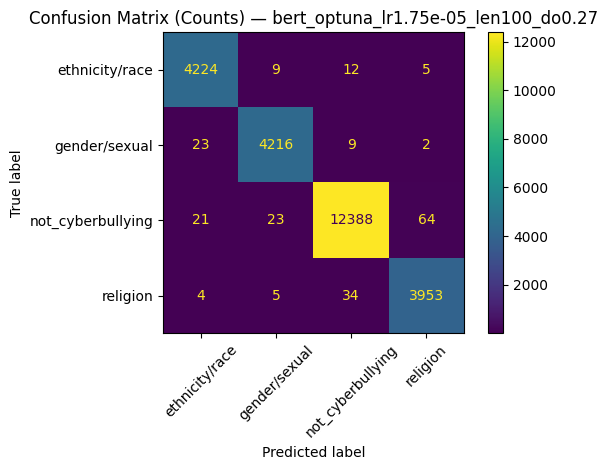

[I 2025-12-16 14:48:59,418] Trial 1 finished with value: 0.9907970550576184 and parameters: {'lr': 1.7539602249142682e-05, 'max_len': 100, 'dropout': 0.27205179607726965}. Best is trial 0 with value: 0.9914772727272727.


✅ Saved predictions: results_bert/optuna_search/bert_optuna_lr1.75e-05_len100_do0.27_test_predictions.csv
✅ Saved metrics: results_bert/optuna_search/bert_optuna_lr1.75e-05_len100_do0.27_metrics.json
✅ Saved history: results_bert/optuna_search/bert_optuna_lr1.75e-05_len100_do0.27_history.csv
[bert_optuna_lr3.44e-05_len128_do0.30] Epoch 1/2 | Train Loss 0.1187 Acc 96.55% | Val Loss 0.0446 Acc 99.13%
✅ Saved BEST checkpoint: results_bert/optuna_search/bert_optuna_lr3.44e-05_len128_do0.30_best.pt (Val Acc 99.13%)
[bert_optuna_lr3.44e-05_len128_do0.30] Epoch 2/2 | Train Loss 0.0341 Acc 99.19% | Val Loss 0.0357 Acc 99.25%
✅ Saved BEST checkpoint: results_bert/optuna_search/bert_optuna_lr3.44e-05_len128_do0.30_best.pt (Val Acc 99.25%)
[bert_optuna_lr3.44e-05_len128_do0.30] Training time: 605.76 seconds

TEST RESULTS | Loss: 0.0325 | Accuracy: 99.29%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
 

<Figure size 700x600 with 0 Axes>

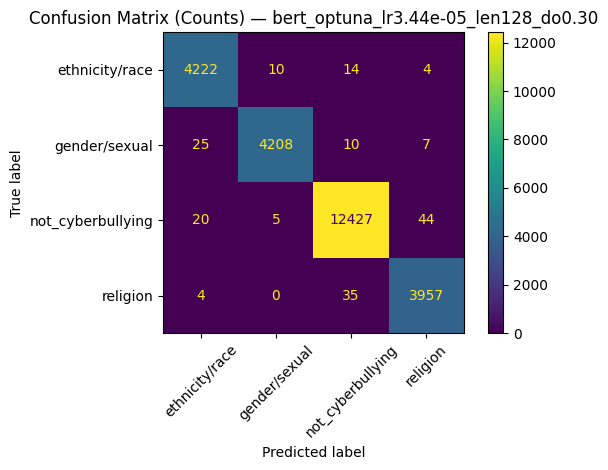

[I 2025-12-16 15:00:30,079] Trial 2 finished with value: 0.9924775928297055 and parameters: {'lr': 3.436955010271621e-05, 'max_len': 128, 'dropout': 0.29545703432359016}. Best is trial 2 with value: 0.9924775928297055.


✅ Saved predictions: results_bert/optuna_search/bert_optuna_lr3.44e-05_len128_do0.30_test_predictions.csv
✅ Saved metrics: results_bert/optuna_search/bert_optuna_lr3.44e-05_len128_do0.30_metrics.json
✅ Saved history: results_bert/optuna_search/bert_optuna_lr3.44e-05_len128_do0.30_history.csv
Best params: {'lr': 3.436955010271621e-05, 'max_len': 128, 'dropout': 0.29545703432359016}
Best best_val_acc: 0.9924775928297055


In [16]:
import optuna

def objective(trial):
    set_seed(42)

    lr = trial.suggest_float("lr", 1e-5, 5e-5, log=True)
    max_len = trial.suggest_categorical("max_len", [100, 128])
    dropout = trial.suggest_float("dropout", 0.20, 0.50)

    run_name = f"bert_optuna_lr{lr:.2e}_len{max_len}_do{dropout:.2f}"
    metrics, _ = run_bert_experiment(
        run_name=run_name,
        max_len=max_len,
        batch_size=32,
        epochs=2,           # short for tuning
        lr=lr,
        dropout=dropout,
        unfreeze_last_n=2,
        save_dir="results_bert/optuna_search"
    )
    return metrics["best_val_acc"]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)   # increase to 8–12 if you have time

print("Best params:", study.best_params)
print("Best best_val_acc:", study.best_value)


[bert_final_best] Epoch 1/5 | Train Loss 0.1187 Acc 96.55% | Val Loss 0.0446 Acc 99.13%
✅ Saved BEST checkpoint: results_bert/final/bert_final_best_best.pt (Val Acc 99.13%)
[bert_final_best] Epoch 2/5 | Train Loss 0.0341 Acc 99.19% | Val Loss 0.0357 Acc 99.25%
✅ Saved BEST checkpoint: results_bert/final/bert_final_best_best.pt (Val Acc 99.25%)
[bert_final_best] Epoch 3/5 | Train Loss 0.0230 Acc 99.45% | Val Loss 0.0310 Acc 99.38%
✅ Saved BEST checkpoint: results_bert/final/bert_final_best_best.pt (Val Acc 99.38%)
[bert_final_best] Epoch 4/5 | Train Loss 0.0175 Acc 99.51% | Val Loss 0.0337 Acc 99.08%
[bert_final_best] Epoch 5/5 | Train Loss 0.0125 Acc 99.65% | Val Loss 0.0404 Acc 98.82%
[bert_final_best] Training time: 1513.19 seconds

TEST RESULTS | Loss: 0.0286 | Accuracy: 99.46%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      1.00      0.99      4250
    gender/sexual       1.00      0.99      0.99      4250
not_cy

<Figure size 700x600 with 0 Axes>

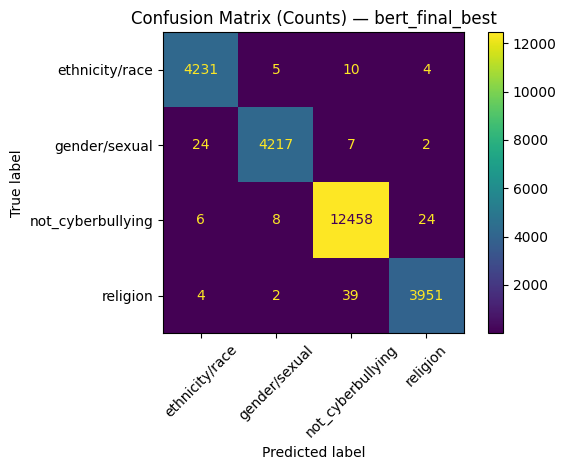

✅ Saved predictions: results_bert/final/bert_final_best_test_predictions.csv
✅ Saved metrics: results_bert/final/bert_final_best_metrics.json
✅ Saved history: results_bert/final/bert_final_best_history.csv


In [17]:
best = {
    "lr": 3.436955010271621e-05,
    "max_len": 128,
    "dropout": 0.29545703432359016
}

set_seed(42)

final_metrics, final_history = run_bert_experiment(
    run_name="bert_final_best",
    max_len=best["max_len"],
    batch_size=32,
    epochs=5,          # or 8–10 if you want
    lr=best["lr"],
    dropout=best["dropout"],
    unfreeze_last_n=2,
    save_dir="results_bert/final"
)


✅ Loaded checkpoint: results_bert/final/bert_final_best_best.pt
Config: {'model_name': 'google-bert/bert-base-uncased', 'max_len': 128, 'batch_size': 32, 'epochs': 5, 'lr': 3.436955010271621e-05, 'dropout': 0.29545703432359016, 'unfreeze_last_n': 2}

✅ TEST RESULTS | Loss: 0.0227 | Accuracy: 99.46%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      1.00      0.99      4250
    gender/sexual       1.00      0.99      0.99      4250
not_cyberbullying       1.00      1.00      1.00     12496
         religion       0.99      0.99      0.99      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992

Confusion Matrix (numbers):
[[ 4231     5    10     4]
 [   24  4217     7     2]
 [    6     8 12458    24]
 [    4     2    39  3951]]


<Figure size 700x600 with 0 Axes>

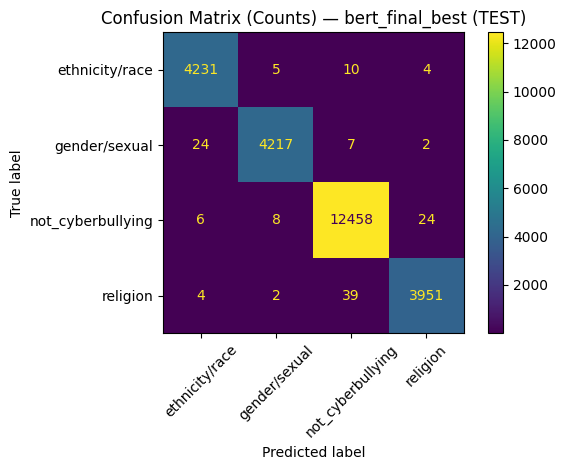

✅ Saved test predictions to: results_bert/final/bert_final_best_TEST_predictions.csv


In [18]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ---- 1) Path to your best checkpoint
CKPT_PATH = "results_bert/final/bert_final_best_best.pt"

# ---- 2) Load checkpoint
ckpt = torch.load(CKPT_PATH, map_location=device, weights_only=False)
config = ckpt["config"]
label_classes = ckpt["label_classes"]

print("✅ Loaded checkpoint:", CKPT_PATH)
print("Config:", config)

# ---- 3) Restore label encoder
le = LabelEncoder()
le.classes_ = label_classes

# ---- 4) Rebuild tokenizer + base model
tokenizer = AutoTokenizer.from_pretrained(config["model_name"])
base_model = AutoModel.from_pretrained(config["model_name"])

# ---- 5) Rebuild your classifier model (MUST match your training architecture)
class MyModel(nn.Module):
    def __init__(self, base_model, num_classes, dropout=0.30):
        super().__init__()
        self.base = base_model
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 256)
        self.act = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.base(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]
        x = self.dropout1(cls)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout2(x)
        return self.fc2(x)

model = MyModel(base_model, num_classes=len(le.classes_), dropout=config["dropout"]).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

# ---- 6) Build test_loader again (same MAX_LEN used in training)
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, tokenizer, max_len):
        self.X = X
        self.Y = Y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = str(self.X[idx])
        label = int(self.Y[idx])

        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
            "text": text
        }

# IMPORTANT: assumes X_test and y_test already exist from your 50/25/25 split cell
test_ds = MyDataset(X_test, y_test, tokenizer, config["max_len"])
test_loader = DataLoader(test_ds, batch_size=config["batch_size"], shuffle=False)

# ---- 7) Loss (unweighted for reporting; you can also use weighted if you want)
criterion = nn.CrossEntropyLoss()

# ---- 8) Run testing
test_loss_sum, test_correct, test_total = 0.0, 0, 0
all_preds, all_labels, all_texts = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        test_loss_sum += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=1)

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        all_texts.extend(batch["text"])

avg_test_loss = test_loss_sum / test_total
avg_test_acc = test_correct / test_total

print(f"\n✅ TEST RESULTS | Loss: {avg_test_loss:.4f} | Accuracy: {avg_test_acc*100:.2f}%\n")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix (numbers):")
print(cm)

# ---- 9) Colored confusion matrix diagram
plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Counts) — bert_final_best (TEST)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- 10) (Optional) Save predictions
pred_df = pd.DataFrame({
    "text": all_texts,
    "true_label": [le.classes_[i] for i in all_labels],
    "pred_label": [le.classes_[i] for i in all_preds],
})
pred_path = "results_bert/final/bert_final_best_TEST_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print("✅ Saved test predictions to:", pred_path)
